# **EPIC 4 - MODELING**

## Objectives

- Train and validate the model on the prepared image datasets.

### Acceptance Criteria
- Image sets should initially be 70% training, 15% validation, and 15% test.
- Model performs 'well' on validation set - otherwise, return to Pre-process images #4

## Tasks
- Split the images into training, validation, and test sets.
- Plot the numbers of images in each set (LO 3.1).

## Inputs

- inputs/[datasets]: folders containing the prepare image datasets for each animal.

## Outputs

- Image datasets for each animal split into training, validation, and test sets.

---

# Import packages

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Set working directory

In [24]:
current_dir = os.getcwd()
print("Current working directory is:", current_dir)

Current working directory is: /Users/gingermale/Documents/repos/PP5/pet-image-classifier


In [4]:
os.chdir(os.path.dirname(current_dir)) # Change the current working directory to the parent directory
current_dir = os.getcwd() # Get the new current working directory
print("Changing the working directory to parent folder:", current_dir)

Changing the working directory to parent folder: /Users/gingermale/Documents/repos/PP5/pet-image-classifier


# Set input and output paths

In [25]:
work_dir = current_dir + '/inputs'
data_dir = work_dir + '/dataset'
train_dir = work_dir + '/train'
validate_dir = work_dir + '/validate'
test_dir = work_dir + '/test'

version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
  print('Old version is already available. Create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available. Create a new version.


# Set labels

In [26]:
labels = [name for name in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, name))]

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['Sphynx', 'Burmese', 'Springer Spaniel', 'Poison Dart Frog', 'Degu', 'Chinchilla', 'Rottweiler', 'Guinea Pig', 'American Shorthair', 'Lovebird', 'Egyptian Mau', 'Wallaby', 'Budgerigar', 'Quaker Parrot', 'African Dwarf Frog', 'Dachshund', 'Hyacinth Macaw', 'Canary', 'French Bulldog', 'Shih Tzu', 'Chameleon', 'Great Dane', 'Devon Rex', 'Ragdoll', 'Hamster', 'Abyssinian', 'Jack Russell Terrier', 'Pug', 'Siamese', 'Maine Coon', 'Bengal', 'Bearded Dragon', 'Scottish Fold', 'Rat', 'Ferret', 'Parrotlet', 'Beagle', 'Cockatoo', 'Cocker Spaniel', 'Crested Gecko', 'British Shorthair', 'Cockatiel', 'Labrador Retriever', 'Mouse', 'African Grey Parrot', 'American Toad', 'German Shepherd', 'Border Collie', 'Finch', "Bourke's Parakeet", 'Pionus Parrot', "White's Tree Frog", 'Rabbit', 'Russian Blue', 'Persian', 'Yorkshire Terrier', 'Poodle', 'Red-eyed Tree Frog', 'Leopard Gecko', 'Green Iguana', 'Salamander', 'Horse', 'Horned Toad', 'Sugar Glider', 'Axolotl', 'Golden Retriever', 'Boxer

# Split the images

First, we install sklearn library to split the images into training, validation, and test sets.

In [3]:
%pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 2.4 MB/s eta 0:00:0000:0100:01
  Using cached scipy-1.10.1-cp38-cp38-macosx_12_0_arm64.whl (28.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 3.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [40]:
import shutil
import os
import random

def split_train_validate_test_images(data_dir, inputs_dir, train_set_ratio, validate_set_ratio, test_set_ratio):
  
  if train_set_ratio + validate_set_ratio + test_set_ratio != 1.0:
    print("train_set_ratio + validate_set_ratio + test_set_ratio should sum 1.0")
    return

  # gets classes labels
  labels = [name for name in os.listdir(data_dir) if name != '.DS_Store'] # ignore .DS_Store

  # create train, test folders with classess labels sub-folder
  for folder in ['train','validate','test']:
    for label in labels:
      os.makedirs(os.path.join(inputs_dir, folder, label), exist_ok=True)

  for label in labels:
    path = os.path.join(data_dir, label)
    if os.path.isdir(path):
        files = [name for name in os.listdir(path) if name != '.DS_Store'] # ignore .DS_Store
        random.shuffle(files)

    train_set_files_qty = int(len(files) * train_set_ratio)
    validate_set_files_qty = int(len(files) * validate_set_ratio)

    count = 1
    for file_name in files:
      if count <= train_set_files_qty:
        # move given file to train set
        shutil.move(os.path.join(data_dir, label, file_name),
                    os.path.join(inputs_dir, 'train', label, file_name))
        

      elif count <= (train_set_files_qty + validate_set_files_qty ):
        # move given file to validate set
        shutil.move(os.path.join(data_dir, label, file_name),
                    os.path.join(inputs_dir, 'validate', label, file_name))

      else:
        # move given file to test set
        shutil.move(os.path.join(data_dir, label, file_name),
                    os.path.join(inputs_dir, 'test', label, file_name))
        
      count += 1

    shutil.rmtree(os.path.join(data_dir, label))  # use shutil.rmtree() instead of os.rmdir()

In [41]:
split_train_validate_test_images(data_dir,
                        train_set_ratio = 0.7,
                        validate_set_ratio=0.15,
                        test_set_ratio=0.15
                        )

# Number of images in each set (LO 3.1)

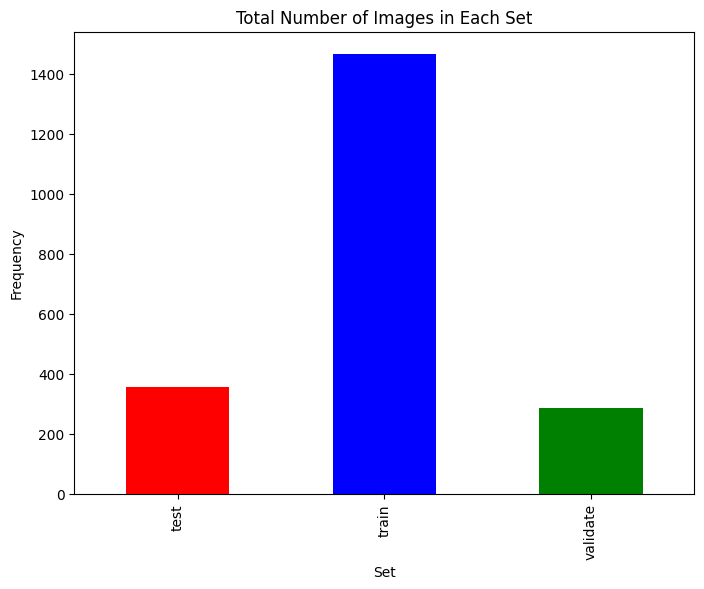

In [45]:
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

# Update the work_dir to the new location
work_dir = '/Users/gingermale/Documents/repos/PP5/pet-image-classifier'

for folder in ['train', 'validate', 'test']:
    labels_dir = [f for f in os.listdir(os.path.join(work_dir, 'inputs', folder)) if not f.startswith('.')]
    for label in labels_dir:
        files = [f for f in os.listdir(os.path.join(work_dir, 'inputs', folder, label)) if not f.startswith('.')]
        count = len(files)
        df_to_append = pd.DataFrame([{'Set': folder, 'Label': label, 'Frequency': count}], columns=['Set', 'Label', 'Frequency'])
        df_freq = pd.concat([df_freq, df_to_append], ignore_index=True)

# Summarize data
df_summary = df_freq.groupby('Set')['Frequency'].sum().reset_index()

# Plotting
df_summary.plot(x='Set', y='Frequency', kind='bar', legend=False, color=['red', 'blue', 'green'], figsize=(8, 6))
plt.ylabel('Frequency')
plt.title('Total Number of Images in Each Set')
plt.show()

In [47]:
df_freq = pd.DataFrame(columns=['Set', 'Label', 'Frequency'])

# Update the work_dir to the new location
work_dir = '/Users/gingermale/Documents/repos/PP5/pet-image-classifier'

for folder in ['train', 'validate', 'test']:
    labels_dir = [f for f in os.listdir(os.path.join(work_dir, 'inputs', folder)) if not f.startswith('.')]
    for label in labels_dir:
        files = [f for f in os.listdir(os.path.join(work_dir, 'inputs', folder, label)) if not f.startswith('.')]
        count = len(files)
        df_to_append = pd.DataFrame([{'Set': folder, 'Label': label, 'Frequency': count}], columns=['Set', 'Label', 'Frequency'])
        df_freq = pd.concat([df_freq, df_to_append], ignore_index=True)

print(df_freq)

       Set                Label Frequency
0    train               Sphynx        21
1    train              Burmese        21
2    train     Springer Spaniel        21
3    train     Poison Dart Frog        21
4    train                 Degu        20
..     ...                  ...       ...
208   test                Boxer         5
209   test               Gerbil         5
210   test              Bulldog         5
211   test  Miniature Schnauzer         5
212   test         Eastern Newt         5

[213 rows x 3 columns]


---

# Augment Images

In [48]:
import tensorflow as tf

In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Initialize ImageDataGenerator

In [50]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Augment training images

In [12]:
batch_size = 20 # Set batch size
image_shape = [150, 150, 3]
train_set = augmented_image_data.flow_from_directory(train_dir,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 0 images belonging to 0 classes.


{}